In [1]:
import os
import random
from io import StringIO

import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from lifelines import KaplanMeierFitter, LogNormalFitter, WeibullFitter
from lifelines.utils import survival_table_from_events
from scipy.stats import binom, lognorm, norm, weibull_min
import seaborn as sns

In [2]:

y = np.array([56]*3000 + [117]*1500 + [266]*1250 + [315]*1150 + [405]*1100 + [501]*1000 +
                 [615]*1100 + [704]*1150 + [838]*120 + [901]*130 + [1010]*125 + [1111]*100 +
                 [1250]*50 + [1350]*400 + [1500]*300 + [1600]*100 + [1700]*5 + [1870]*3 +
                 [2070]*4 + [1550]*1 + [1050]*1 + [1000]*1 + [500]*1 + [350]*1 + [250]*1)

censored = np.array([True]*3000 + [True]*1500 + [True]*1250+ [True]*1150 + [True]*1100 + [True]*1000 +
                 [True]*1100 + [True]*1150 + [True]*120 + [True]*130 + [True]*125 + [True]*100 +
                 [True]*50 + [True]*400 + [True]*300 + [True]*100 + [True]*5 + [True]*3 +
                 [True]*4 + [False]*1 + [False]*1 + [False]*1 + [False]*1 + [False]*1 + [False]*1)


def weibull_lccdf(y, alpha, beta):
    """Log complementary cdf of Weibull distribution."""
    return -((y / beta) ** alpha)

priors = {"beta": [100, 15000], "alpha": [4, 1, 0.02, 8]}
priors_informative = {"beta": [10000, 500], "alpha": [2, 0.5, 0.02, 3]}


def make_model(p, info=False):
    with pm.Model() as model:
        if info:
            beta = pm.Normal("beta", p["beta"][0], p["beta"][1])
        else:
            beta = pm.Uniform("beta", p["beta"][0], p["beta"][1])
        alpha = pm.TruncatedNormal(
            "alpha", p["alpha"][0], p["alpha"][1], lower=p["alpha"][2], upper=p["alpha"][3]
        )
        

        
        y_obs = pm.Weibull("y_obs", alpha=alpha, beta=beta, observed=y[~censored])
        y_cens = pm.Potential("y_cens", weibull_lccdf(y[censored], alpha, beta))
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(draws=1000,tune=1000, cores=32,step=pm.Slice()))
        idata.extend(pm.sample_posterior_predictive(idata))

    return idata, model

idata, model = make_model(priors)
idata_informative, model = make_model(priors_informative, info=True)

/tmp/ipykernel_4359/1667726696.py:34: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]
Multiprocess sampling (32 chains in 32 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 10 seconds.
/tmp/ipykernel_4359/1667726696.py:36: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_4359/1667726696.py:34: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]
Multiprocess sampling (32 chains in 32 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 11 seconds.
/tmp/ipykernel_4359/1667726696.py:36: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


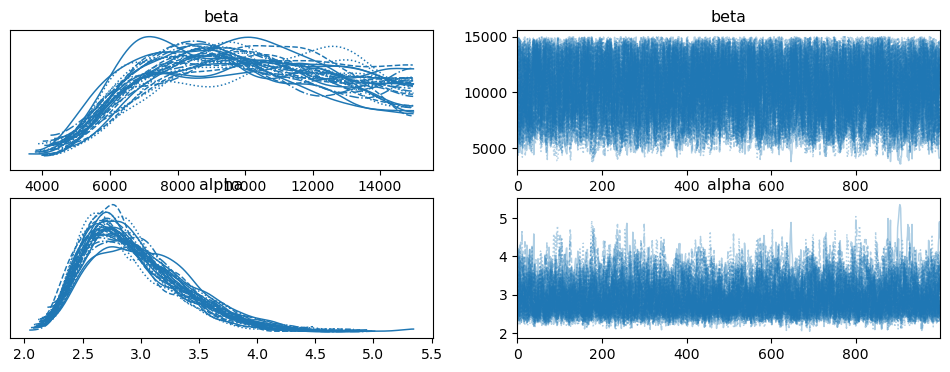

In [3]:
az.plot_trace(idata);

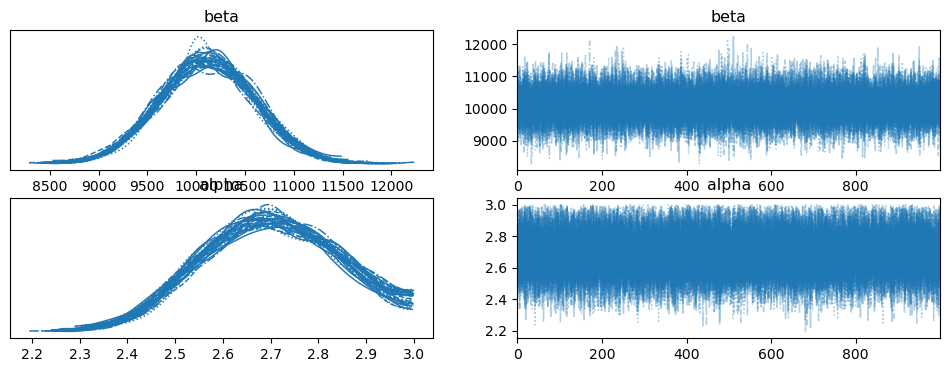

In [4]:
az.plot_trace(idata_informative);

In [5]:
def ecdf(sample):
    # convert sample to a numpy array, if it isn't already
    sample = np.atleast_1d(sample)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob

In [6]:
joint_draws = az.extract(idata, num_samples=1000)[["alpha", "beta"]]
alphas = joint_draws["alpha"].values
betas = joint_draws["beta"].values

joint_draws_informative = az.extract(idata_informative, num_samples=1000)[["alpha", "beta"]]
alphas_informative = joint_draws_informative["alpha"].values
betas_informative = joint_draws_informative["beta"].values

draws = pm.draw(pm.Weibull.dist(alpha=np.mean(alphas), beta=np.mean(betas)), 1000)

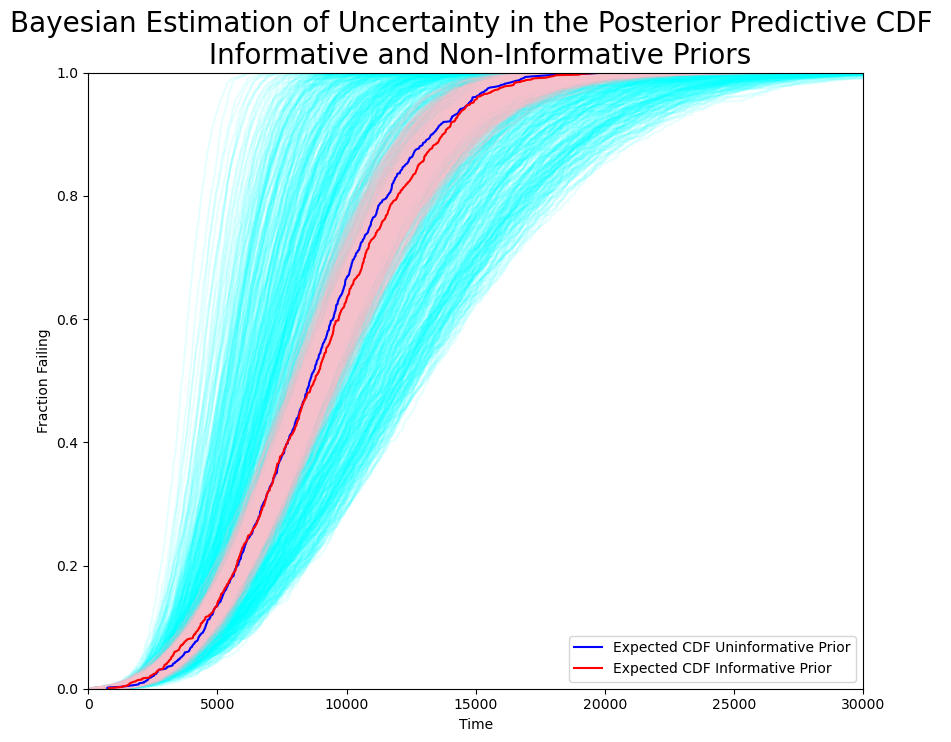

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

hist_data = []
for i in range(1000):
    draws = pm.draw(pm.Weibull.dist(alpha=alphas[i], beta=betas[i]), 1000)
    qe, pe = ecdf(draws)
    lkup = dict(zip(pe, qe))
    hist_data.append([lkup[0.1], lkup[0.05]])
    ax.plot(qe, pe, color="cyan", alpha=0.1)

hist_data_info = []
for i in range(1000):
    draws = pm.draw(pm.Weibull.dist(alpha=alphas_informative[i], beta=betas_informative[i]), 1000)
    qe, pe = ecdf(draws)
    lkup = dict(zip(pe, qe))
    hist_data_info.append([lkup[0.1], lkup[0.05]])
    ax.plot(qe, pe, color="pink", alpha=0.1)

hist_data = pd.DataFrame(hist_data, columns=["p10", "p05"])
hist_data_info = pd.DataFrame(hist_data_info, columns=["p10", "p05"])

draws = pm.draw(pm.Weibull.dist(alpha=np.mean(alphas), beta=np.mean(betas)), 1000)
qe, pe = ecdf(draws)
ax.plot(qe, pe, color="blue", label="Expected CDF Uninformative Prior")

draws = pm.draw(pm.Weibull.dist(alpha=np.mean(alphas_informative), beta=np.mean(betas_informative)), 1000)
qe, pe = ecdf(draws)
ax.plot(qe, pe, color="red", label="Expected CDF Informative Prior")

ax.set_xlim(0, 30000)
ax.set_title("Bayesian Estimation of Uncertainty in the Posterior Predictive CDF \n Informative and Non-Informative Priors", fontsize=20)
ax.set_ylabel("Fraction Failing")
ax.set_xlabel("Time")
ax.legend()
ax.set_ylim(0, 1);

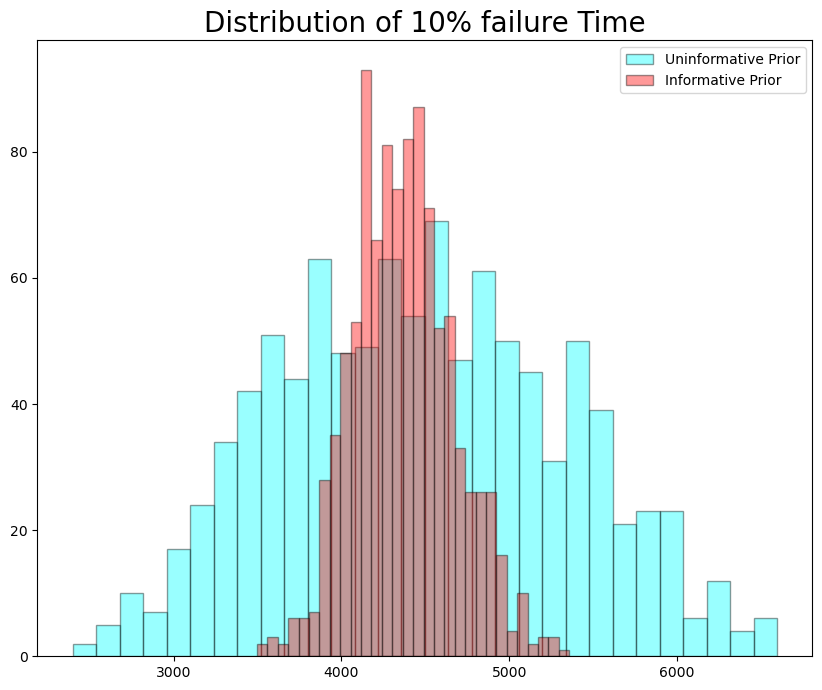

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.hist(hist_data["p10"], bins=30, ec="black", color="cyan", alpha=0.4, label="Uninformative Prior")
ax1.hist(hist_data_info["p10"], bins=30, ec="black", color="red", alpha=0.4, label="Informative Prior")
ax1.set_title("Distribution of 10% failure Time", fontsize=20);
ax1.legend();

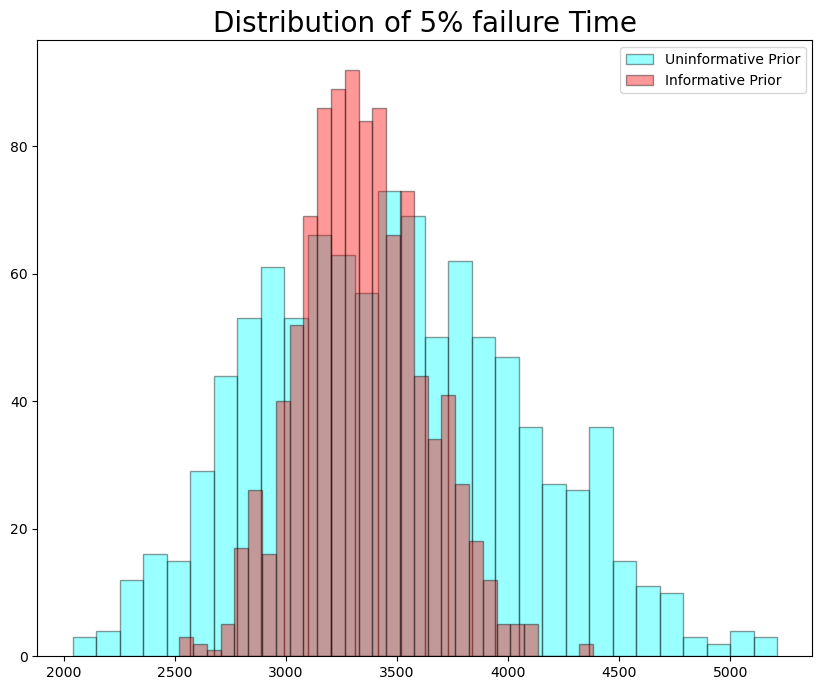

In [9]:
fig, ax2 = plt.subplots(figsize=(10, 8))

ax2.hist(hist_data["p05"], bins=30, ec="black", color="cyan", alpha=0.4, label="Uninformative Prior")
ax2.hist(hist_data_info["p05"], bins=30, ec="black", color="red", alpha=0.4, label="Informative Prior")
ax2.legend()
ax2.set_title("Distribution of 5% failure Time", fontsize=20);


In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,10032.899,2676.570,5979.420,14998.662,45.831,32.410,3405.0,5947.0,1.01
alpha,2.938,0.425,2.267,3.741,0.007,0.005,3595.0,5782.0,1.01


In [11]:
az.summary(idata_informative)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,10113.563,484.551,9215.514,11036.404,2.978,2.106,26474.0,23633.0,1.0
alpha,2.699,0.141,2.455,2.969,0.001,0.001,19950.0,14904.0,1.0


In [12]:
hist_data

,p10,p05
0,6591.473844,4951.200250
1,4577.282212,3651.965380
2,6221.138952,4338.159763
3,5431.039168,4257.442113
4,4999.849281,3665.744651
...,...,...
995,3523.137731,2832.637353
996,4914.835908,3781.318843
997,5178.380481,3919.165218
998,4425.572511,3189.084775


In [13]:
import xarray as xr

from xarray_einstats.stats import XrContinuousRV, XrDiscreteRV


def PI_failures(joint_draws, lp, up, n_at_risk):
    fit = XrContinuousRV(weibull_min, joint_draws["alpha"], scale=joint_draws["beta"])
    rho = fit.cdf(up) - fit.cdf(lp) / (1 - fit.cdf(lp))
    lub = XrDiscreteRV(binom, n_at_risk, rho).ppf([0.05, 0.95])
    lb, ub = lub.sel(quantile=0.05, drop=True), lub.sel(quantile=0.95, drop=True)
    point_prediction = n_at_risk * rho
    return xr.Dataset(
        {"rho": rho, "n_at_risk": n_at_risk, "lb": lb, "ub": ub, "expected": point_prediction}
    )


output_ds = PI_failures(joint_draws, 100, 700, 1700)
output_ds

<xarray.Dataset>
Dimensions:    (sample: 1000)
Coordinates:
  * sample     (sample) object MultiIndex
  * chain      (sample) int64 5 10 18 5 6 31 13 17 10 ... 1 19 30 24 0 25 30 30
  * draw       (sample) int64 223 532 378 964 559 447 ... 85 697 316 656 392 573
Data variables:
    rho        (sample) float64 0.0001476 0.001129 ... 0.0003777 0.001063
    n_at_risk  int64 1700
    lb         (sample) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ub         (sample) float64 1.0 4.0 3.0 2.0 2.0 3.0 ... 2.0 2.0 4.0 2.0 4.0
    expected   (sample) float64 0.251 1.92 1.255 0.7559 ... 1.619 0.6422 1.807

In [14]:
def cost_func(failures, power):
    #Imagined cost function for failing item e.g. refunds required
    return np.power(failures, power)

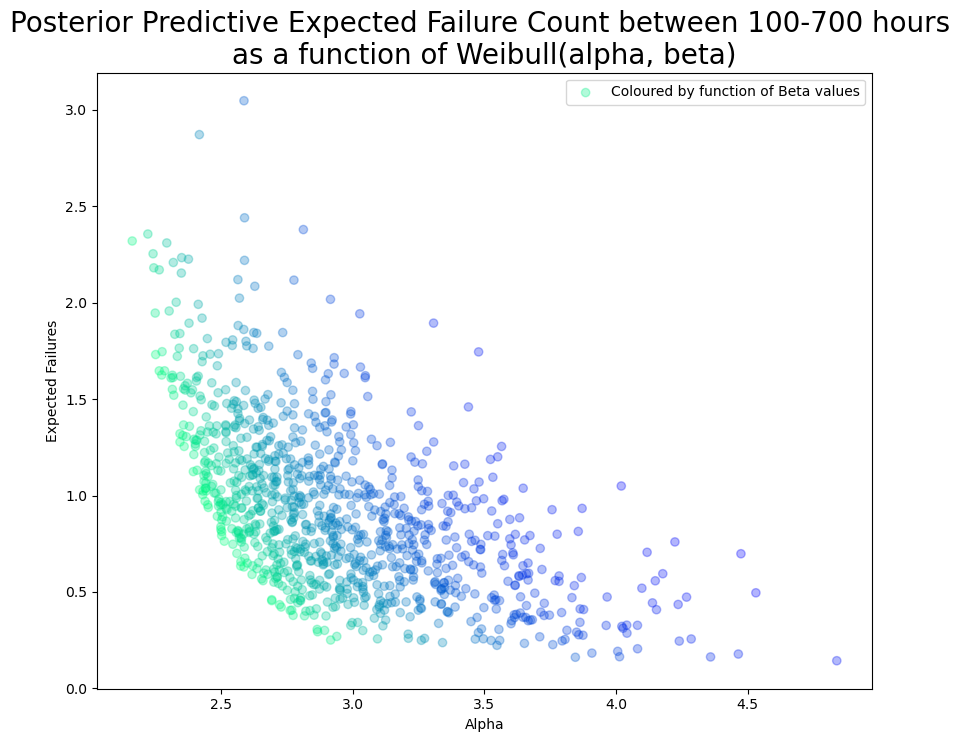

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    joint_draws["alpha"],
    output_ds["expected"],
    c=joint_draws["beta"],
    cmap=cm.winter,
    alpha=0.3,
    label="Coloured by function of Beta values",
)
ax.legend()
ax.set_ylabel("Expected Failures")
ax.set_xlabel("Alpha")
ax.set_title(
    "Posterior Predictive Expected Failure Count between 100-700 hours \nas a function of Weibull(alpha, beta)",
    fontsize=20,
);

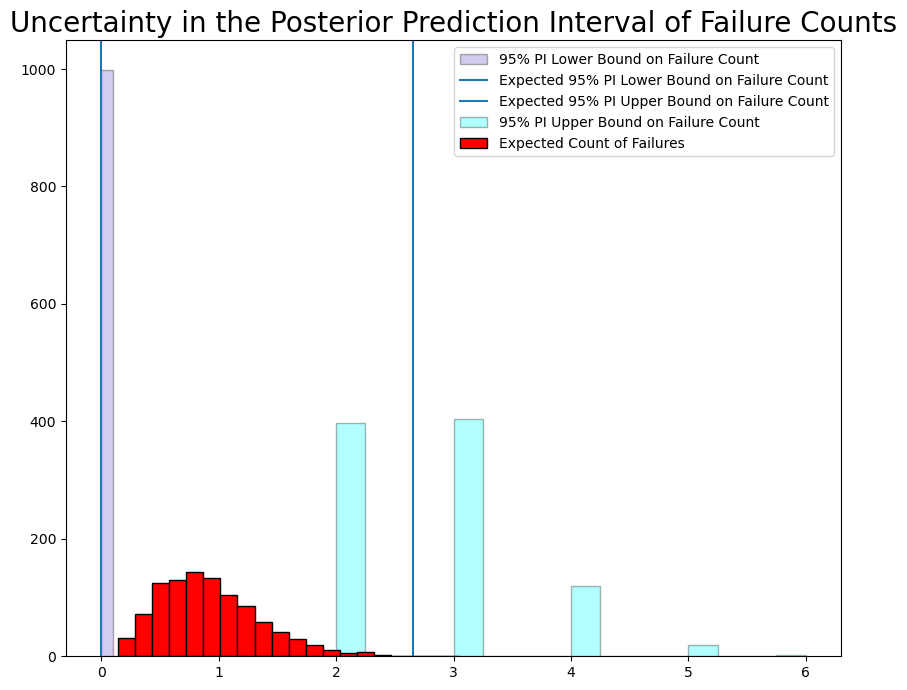

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.hist(
    output_ds["lb"],
    ec="black",
    color="slateblue",
    label="95% PI Lower Bound on Failure Count",
    alpha=0.3,
)
ax1.axvline(output_ds["lb"].mean(), label="Expected 95% PI Lower Bound on Failure Count")
ax1.axvline(output_ds["ub"].mean(), label="Expected 95% PI Upper Bound on Failure Count")
ax1.hist(
    output_ds["ub"],
    ec="black",
    color="cyan",
    label="95% PI Upper Bound on Failure Count",
    bins=20,
    alpha=0.3,
)
ax1.hist(
    output_ds["expected"], ec="black", color="red", label="Expected Count of Failures", bins=20
)
ax1.set_title("Uncertainty in the Posterior Prediction Interval of Failure Counts", fontsize=20)
ax1.legend()


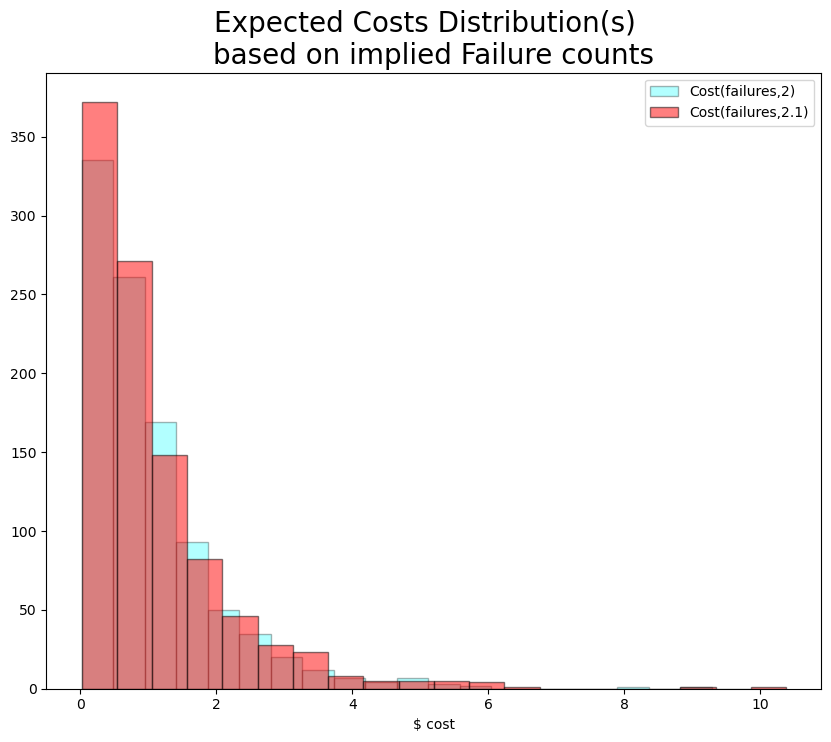

In [17]:
fig, ax2 = plt.subplots(figsize=(10, 8))

ax2.set_title("Expected Costs Distribution(s)  \nbased on implied Failure counts", fontsize=20)
ax2.hist(
    cost_func(output_ds["expected"], 2),
    label="Cost(failures,2)",
    color="cyan",
    alpha=0.3,
    ec="black",
    bins=20,
)
ax2.hist(
    cost_func(output_ds["expected"], 2.1),
    label="Cost(failures,2.1)",
    color="red",
    alpha=0.5,
    ec="black",
    bins=20,
)
ax2.set_xlabel("$ cost")
ax2.legend();

In [18]:
mle_fit = weibull_min(c=2, scale=10_000)
rho = mle_fit.cdf(1000) - mle_fit.cdf(100) / (1 - mle_fit.cdf(100))
print("Rho:", rho)
print("N at Risk:", 1700)
print("Expected Number Failing in between 100 and 700 hours:", 1700 * rho)
print("Lower Bound 95% PI :", binom(1700, rho).ppf(0.05))
print("Upper Bound 95% PI:", binom(1700, rho).ppf(0.95))

Rho: 0.009850161250665276
N at Risk: 1700
Expected Number Failing in between 100 and 700 hours: 16.74527412613097
Lower Bound 95% PI : 10.0
Upper Bound 95% PI: 24.0
